导入库

In [1]:
import datetime as dt
import gc
import logging
import time
from functools import lru_cache

import akshare as ak
import numpy as np
import pandas as pd
import scipy.interpolate as spi
import seaborn as sns
from dateutil import relativedelta as rd
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from matplotlib import ticker
from numba import jit, njit, prange
from scipy.optimize import brentq as bq
from tqdm.auto import tqdm, trange

pd.set_option("display.max_columns", None)

plt.rcParams["font.sans-serif"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False

logging.basicConfig(level=logging.INFO)

%config InlineBackend.figure_format = 'retina'

# 自定义雪球类

雪球基类

In [2]:
class SnowballOption:
    def __init__(
        self,
        r,
        q,
        vol,
        s0,
        s,
        start_date,
        end_date,
        calendar,
        lock_term,
        coupon_out,
        coupon_div,
        barrier_out,
        barrier_in,
    ):
        # BS公式参数
        self.r = r  # 无风险利率
        self.q = q  # 股息率
        self.vol = vol  # 波动率
        self.s0 = s0  # 期初标的价格
        self.s = s  # 名义本金
        # 雪球独有参数
        self.start_date = start_date  # 观察起始日期
        self.end_date = end_date  # 结束日期
        self.calendar = calendar  # 交易日历
        self.lock_term = lock_term  # 锁定期
        self.coupon_out = coupon_out  # 敲出票息
        self.coupon_div = coupon_div  # 红利票息
        self.barrier_out = barrier_out  # 敲出障碍价格
        self.barrier_in = barrier_in  # 敲入障碍价格

        # 初始化参数
        self.initialize_params()

    def initialize_params(self):
        # 所有交易日期
        self.trade_dates = self.calendar[
            (self.calendar >= self.start_date) & (self.calendar <= self.end_date)
        ]
        # 敲入观察日
        self.ki_obs_dates = self.trade_dates[
            (
                self.trade_dates
                >= self.start_date + rd.relativedelta(months=self.lock_term)
            )
        ]
        # 敲出观察日
        self.ko_obs_dates = self.trade_dates[
            (
                self.trade_dates
                >= self.start_date + rd.relativedelta(months=self.lock_term)
            )
            & (self.trade_dates.month != self.trade_dates.shift(-1, freq="B").month)
        ]
        # 期权存续时间(年)
        self.maturity = self.trade_dates[-1].year - self.trade_dates[0].year
        # 时间步数
        self.t_steps = len(self.trade_dates) - 1

PDE引擎

In [71]:
class SnowballPDE(SnowballOption):
    def __init__(
        self,
        r,
        q,
        vol,
        s0,
        s,
        start_date,
        end_date,
        calendar,
        lock_term,
        coupon_out,
        coupon_div,
        barrier_out,
        barrier_in,
        s_steps=2000,
        n_smax=4,
        grid_type="uniform",
    ):
        super().__init__(
            r,
            q,
            vol,
            s0,
            s,
            start_date,
            end_date,
            calendar,
            lock_term,
            coupon_out,
            coupon_div,
            barrier_out,
            barrier_in,
        )
        self.s_steps = s_steps  # 价格步数
        self.s_max = n_smax * max(self.s0, self.barrier_out)  # 价格最大值
        self.s_min = 0.0  # 价格最小值
        self.grid_type = grid_type

    def initialize_grid(self):
        """初始化网格"""
        # 价格序列
        if self.grid_type == "uniform":
            self.s_vec = np.linspace(self.s_min, self.s_max, num=self.s_steps + 1)
        elif self.grid_type == "non-uniform":
            # TODO:施工中
            # 修改为非均匀的价格序列，增加定价性能
            s_mid = (self.barrier_out + self.barrier_in) / 2
            total_points = self.s_steps + 1
            if total_points % 2 == 0:
                num_left = int(total_points / 2)
                num_right = int(total_points / 2)
            else:
                num_left = int(total_points / 2)
                num_right = int(total_points / 2) - 1
            le_indices = np.arange(num_left)
            le_points = self.barrier_in + np.sinh(
                np.arcsinh(s_mid - self.barrier_in) * le_indices / (num_left)
                + np.arcsinh(self.s_min - self.barrier_in) * (1 - le_indices / num_left)
            )
            ri_indices = np.arange(num_right)
            ri_points = self.barrier_out + np.sinh(
                np.arcsinh(self.s_max - self.barrier_out) * ri_indices / num_right
                + np.arcsinh(s_mid - self.barrier_out) * (1 - ri_indices / num_right)
            )
            self.s_vec = np.sort(
                np.concatenate(
                    [le_points, ri_points, [self.barrier_in, self.barrier_out]]
                )
            )

        # 时间序列
        self.t_vec = np.linspace(0, self.maturity, num=self.t_steps + 1)
        # 价格索引
        self.i_vec = np.arange(self.s_steps + 1)
        # 时间索引
        self.j_vec = np.arange(self.t_steps + 1)

        # 初始化期权价值网格
        self.otu_grid = np.zeros((self.s_steps + 1, self.t_steps + 1))
        self.dnt_grid = np.zeros((self.s_steps + 1, self.t_steps + 1))
        self.dkop_grid = np.zeros((self.s_steps + 1, self.t_steps + 1))
        self.uop_grid = np.zeros((self.s_steps + 1, self.t_steps + 1))

    def set_boundary_conditions(self):
        """设置边界条件"""
        # 设置敲入线、敲出线的情况
        self.s_mask_out = self.s_vec >= self.barrier_out
        self.s_mask_in = self.s_vec <= self.barrier_in
        self.t_mask_out = self.trade_dates.isin(self.ko_obs_dates)
        self.t_mask_in = self.trade_dates.isin(self.ki_obs_dates)

        # 计算每个交易日到下一个敲出观察日的距离
        next_ko_index = np.searchsorted(self.trade_dates, self.ko_obs_dates)
        # 增加到期日索引
        next_ko_index = np.append(next_ko_index, len(self.trade_dates) - 1)
        # 利用广播机制拓展为t_vec的长度
        next_ko_index = next_ko_index[np.searchsorted(next_ko_index, self.j_vec)]

        # OTU：上涨触碰生效期权
        # 下边界
        # S=S_min时，期权价值为0
        self.otu_grid[0, :] = 0.0
        # 上边界
        # S=S_max时，敲出观察日为C*t_ko的票息，其余各点由下一敲出观察日的票息贴现
        # 计算上边界的价值
        self.otu_grid[-1, :] = (
            self.coupon_out * self.s * self.t_vec[next_ko_index]
        ) * np.exp(-self.r * (self.t_vec[next_ko_index] - self.t_vec))
        # 右边界
        # S>ko时，支付C*T的票息，否则价值为0
        self.otu_grid[self.s_mask_out, -1] = self.coupon_div * self.s * self.maturity
        self.otu_grid[~self.s_mask_out, -1] = 0.0

        # DNT：双边触碰失效期权
        # 下边界
        # S=S_min时，期权价值为0
        self.dnt_grid[0, :] = 0.0
        # 上边界
        # S=S_max时，期权价值为0
        self.dnt_grid[-1, :] = 0.0
        # 右边界
        # S>ko时，支付C*T的票息，否则价值为0
        self.dnt_grid[self.s_mask_out | self.s_mask_in, -1] = 0.0
        self.dnt_grid[~self.s_mask_out & ~self.s_mask_in, -1] = (
            self.coupon_div * self.s * self.maturity
        )

        # DKOP：双边触碰失效看跌期权
        # 下边界
        # S=S_min时，期权价值为0
        self.dkop_grid[0, :] = 0.0
        # 上边界
        # S=S_max时，期权价值为0
        self.dkop_grid[-1, :] = 0.0
        # 右边界
        # ki<S<ko时，payoff为max(ki-S,0)，否则价值为0
        self.dkop_grid[~self.s_mask_in & ~self.s_mask_out, -1] = np.maximum(
            self.s - self.s_vec[~self.s_mask_in & ~self.s_mask_out] / self.s0 * self.s,
            0,
        )
        self.dkop_grid[self.s_mask_in | self.s_mask_out, -1] = 0.0

        # UOP：向上敲出失效看涨期权
        # 下边界
        # S=S_min时，期权价值为T时刻期权价值S0的折现
        self.uop_grid[0, :] = (
            self.s * np.exp(-self.r * (self.maturity - self.t_vec)) - self.s_min
        )
        # 上边界
        # S=S_max时，期权价值为0
        self.uop_grid[-1, :] = 0.0
        # 右边界
        # S<ko时，payoff为max(S-ko,0)，否则价值为0
        self.uop_grid[~self.s_mask_out, -1] = np.maximum(
            self.s - self.s_vec[~self.s_mask_out] / self.s0 * self.s, 0
        )
        self.uop_grid[self.s_mask_out, -1] = 0.0

    @staticmethod
    @njit(
        cache=True, fastmath=True
    )  # 不要使用parallel=True，因为计算有顺序，不能并行。否则计算结果不对
    def TDMA(a, b, c, d):
        """使用numba.jit加速的三对角矩阵求解Thomas算法
        Args:
            a: np.adarray，三对角系数矩阵的下对角线元素向量
            b: np.adarray，三对角系数矩阵的主对角线元素向量
            c: np.adarray，三对角系数矩阵的上对角线元素向量
            d: np.adarray，方程右端向量
        Returns:
            p: np.adarray，方程的解向量，Xp=d
        """
        n = len(d)
        for i in prange(1, n):
            m = a[i - 1] / b[i - 1]
            b[i] = b[i] - m * c[i - 1]
            d[i] = d[i] - m * d[i - 1]
        p = b
        p[-1] = d[-1] / b[-1]
        indices = np.arange(n - 2, -1, -1)  # 创建逆序索引数组
        for j in prange(n - 1):
            i = indices[j]  # 使用逆序索引
            p[i] = (d[i] - c[i] * p[i + 1]) / b[i]
        return p

    def set_matrix(self):
        """生成系数矩阵"""
        self.dt = self.maturity / self.t_steps
        diffusion_square = (self.vol * self.i_vec[1:-1]) ** 2
        drift = (self.r - self.q) * self.i_vec[1:-1]
        self.lower = 0.25 * self.dt * (diffusion_square - drift)
        self.diag = -0.5 * self.dt * (diffusion_square + self.r)
        self.upper = 0.25 * self.dt * (diffusion_square + drift)
        A = (
            np.diag(self.diag)
            + np.diag(self.lower[1:], -1)
            + np.diag(self.upper[:-1], 1)
        )
        self.M1 = np.eye(self.s_steps - 1) - A
        self.M2 = np.eye(self.s_steps - 1) + A

    def solve_PDE(self):
        """求解PDE"""
        grids = [self.otu_grid, self.dnt_grid, self.dkop_grid, self.uop_grid]

        # Crank-Nicolson差分格式求解PDE，使用Thomas算法求解线性方程组
        # 设置矩阵方程等号右侧的V
        # for j in trange(self.t_steps, 0, -1, desc="PDE求解中"):
        for j in range(self.t_steps, 0, -1):
            for index, grid in enumerate(grids):
                f_j = self.M2.dot(grid[1:-1, j])
                f_j[0] += self.lower[0] * (grid[0, j] + grid[0, j - 1])
                f_j[-1] += self.upper[-1] * (grid[-1, j] + grid[-1, j - 1])
                f_j_1 = self.TDMA(
                    self.M1.diagonal(-1).copy(),
                    self.M1.diagonal(0).copy(),
                    self.M1.diagonal(1).copy(),
                    f_j,
                )

                # 根据子网格类型更新期权价值
                if index == 0:
                    # 迭代过程中如果遇到j-1期为敲出观察日，不能覆盖敲出边界以上的期权价值
                    if self.t_mask_out[j - 1]:
                        f_j_1[self.s_mask_out[1:-1]] = (
                            self.coupon_out * self.s * self.t_vec[j - 1]
                        )
                    grid[1:-1, j - 1] = f_j_1
                elif index == 1:
                    # 迭代过程中如果遇到j-1期为敲入/敲出观察日，不能覆盖敲入边界以下/敲出边界以上的期权价值
                    if self.t_mask_in[j - 1]:
                        f_j_1[self.s_mask_in[1:-1]] = 0.0
                    if self.t_mask_out[j - 1]:
                        f_j_1[self.s_mask_out[1:-1]] = 0.0
                    grid[1:-1, j - 1] = f_j_1
                elif index == 2:
                    # 迭代过程中如果遇到j-1期为敲入/敲出观察日，不能覆盖敲入边界以下/敲出边界以上的期权价值
                    if self.t_mask_in[j - 1]:
                        f_j_1[self.s_mask_in[1:-1]] = 0.0
                    if self.t_mask_out[j - 1]:
                        f_j_1[self.s_mask_out[1:-1]] = 0.0
                    grid[1:-1, j - 1] = f_j_1
                elif index == 3:
                    # 迭代过程中如果遇到j-1期为敲出观察日，不能覆盖敲出边界以上的期权价值
                    if self.t_mask_out[j - 1]:
                        f_j_1[self.s_mask_out[1:-1]] = 0.0
                    grid[1:-1, j - 1] = f_j_1

        self.v_grid = self.otu_grid + self.dnt_grid + self.dkop_grid - self.uop_grid

    def interpolate(self, s, t=0):
        """插值计算期初时刻的期权价值

        Returns:
            np.array: 期初时的期权价值
        """
        tck = spi.splrep(self.s_vec, self.v_grid[:, t], k=3)
        return spi.splev(s, tck)

    def price(self):
        """PDE定价实现

        Returns:
            np.array: 期初时的期权价值
        """
        start = time.time()
        # 初始化网格
        self.initialize_grid()
        # 设置边界条件
        self.set_boundary_conditions()
        # 生成系数矩阵
        self.set_matrix()
        # 求解PDE
        self.solve_PDE()
        end = time.time()
        logging.info(f"price执行完成，耗时{end-start}秒")
        # 返回期初时的期权价值
        return self.interpolate(self.s0)

    def delta(self, s, t=0):
        """计算Delta值"""
        s_step = 0.01 * s
        delta = (self.interpolate(s + s_step, t) - self.interpolate(s - s_step, t)) / (
            2 * s_step
        )
        return delta

    def gamma(self, s, t=0):
        """计算Gamma值"""
        s_step = 0.01 * s
        gamma = (
            self.interpolate(s + s_step, t)
            - 2 * self.interpolate(s, t)
            + self.interpolate(s - s_step, t)
        ) / (s_step**2)
        return gamma

    def pv_and_greeks(self):
        pv = self.price()
        delta = self.delta(self.s0)
        gamma = self.gamma(self.s0)
        return {"pv": pv.item(), "delta": delta, "gamma": gamma}

    def pv_grid(self):
        self.price()
        return pd.DataFrame(
            self.v_grid,
            index=self.s_vec,
            columns=self.trade_dates,
        )

蒙特卡洛引擎

In [35]:
class SnowballMC(SnowballOption):
    def __init__(
        self,
        r,
        q,
        vol,
        s0,
        s,
        start_date,
        end_date,
        calendar,
        lock_term,
        coupon_out,
        coupon_div,
        barrier_out,
        barrier_in,
        n_paths=100000,
        seed=3407,
    ):
        super().__init__(
            r,
            q,
            vol,
            s0,
            s,
            start_date,
            end_date,
            calendar,
            lock_term,
            coupon_out,
            coupon_div,
            barrier_out,
            barrier_in,
        )
        self.n_paths = n_paths
        self.seed = seed
        np.random.seed(self.seed)  # 设置随机种子以获得可重复结果
        self.dt = self.maturity / (self.t_steps + 1)

    def simulate_paths(self):
        z = np.random.randn(self.t_steps, self.n_paths)
        ds = np.exp(
            (self.r - self.q - 0.5 * self.vol**2) * self.dt
            + self.vol * np.sqrt(self.dt) * z
        )
        ds = np.clip(ds, 0.9, 1.1)
        self.s_paths = np.cumprod(ds, axis=0) * self.s0
        self.s_paths = np.vstack((self.s0 * np.ones(self.n_paths), self.s_paths))
        self.s_paths = pd.DataFrame(self.s_paths, index=self.trade_dates)

    def payoff(self, s_paths):
        # 每个敲入敲出观察日观察敲入敲出情况
        ko_mask = (s_paths >= self.barrier_out).loc[self.ko_obs_dates, :]
        ki_mask = (s_paths <= self.barrier_in).loc[self.ki_obs_dates, :]
        ko_dates = ko_mask.idxmax(axis=0)
        ko_dates = [self.trade_dates.get_loc(i) for i in ko_dates]
        ko_dates = np.where(ko_mask.any(axis=0), ko_dates, np.nan) * self.dt
        ko = ko_mask.any(axis=0)
        ki = ki_mask.any(axis=0)

        ko_price = np.nansum(
            ko_dates * self.coupon_out * self.s * np.exp(-self.r * ko_dates)
        )
        ki_price = np.nansum(
            (s_paths.iloc[-1, :].loc[~ko & ki] / self.s0 - 1)
            * self.s
            * np.exp(-self.r * self.maturity)
        )
        htm_price = np.nansum(
            self.coupon_div
            * self.s
            * np.exp(-self.r * self.maturity)
            * np.count_nonzero(~ko & ~ki)
        )

        price = (ko_price + ki_price + htm_price) / self.n_paths

        return price

    def price(self):
        start = time.time()
        self.simulate_paths()
        price = self.payoff(self.s_paths)

        end = time.time()
        logging.info(f"price执行完成，耗时{end-start}秒")
        return price

    def delta(self):
        s_step = 0.01
        delta = (
            self.payoff(self.s_paths * (1 + s_step))
            - self.payoff(self.s_paths * (1 - s_step))
        ) / (2 * s_step * self.s0)
        return delta

    def gamma(self):
        s_step = 0.01
        gamma = (
            self.payoff(self.s_paths * (1 + s_step))
            - 2 * self.payoff(self.s_paths)
            + self.payoff(self.s_paths * (1 - s_step))
        ) / ((s_step * self.s0) ** 2)
        return gamma

    def pv_and_greeks(self):
        pv = self.price()
        delta = self.delta()
        gamma = self.gamma()
        return {"pv": pv, "delta": delta, "gamma": gamma}

积分法引擎

# 净值化指数雪球参数研究

获取收盘数据

In [36]:
stock = "000905"

price_df = ak.stock_zh_a_hist(
    symbol=stock,
    period="daily",
    start_date="20050101",
    end_date=dt.datetime.now().strftime("%Y%m%d"),
    adjust="",
)[["日期", "收盘"]]
price_df.set_index("日期", inplace=True)
price_df.index = pd.to_datetime(price_df.index)
price_df.rename(columns={"收盘": stock}, inplace=True)
price_df = price_df.loc[:, stock]

计算指数波动率

Text(0, 0.5, '波动率')

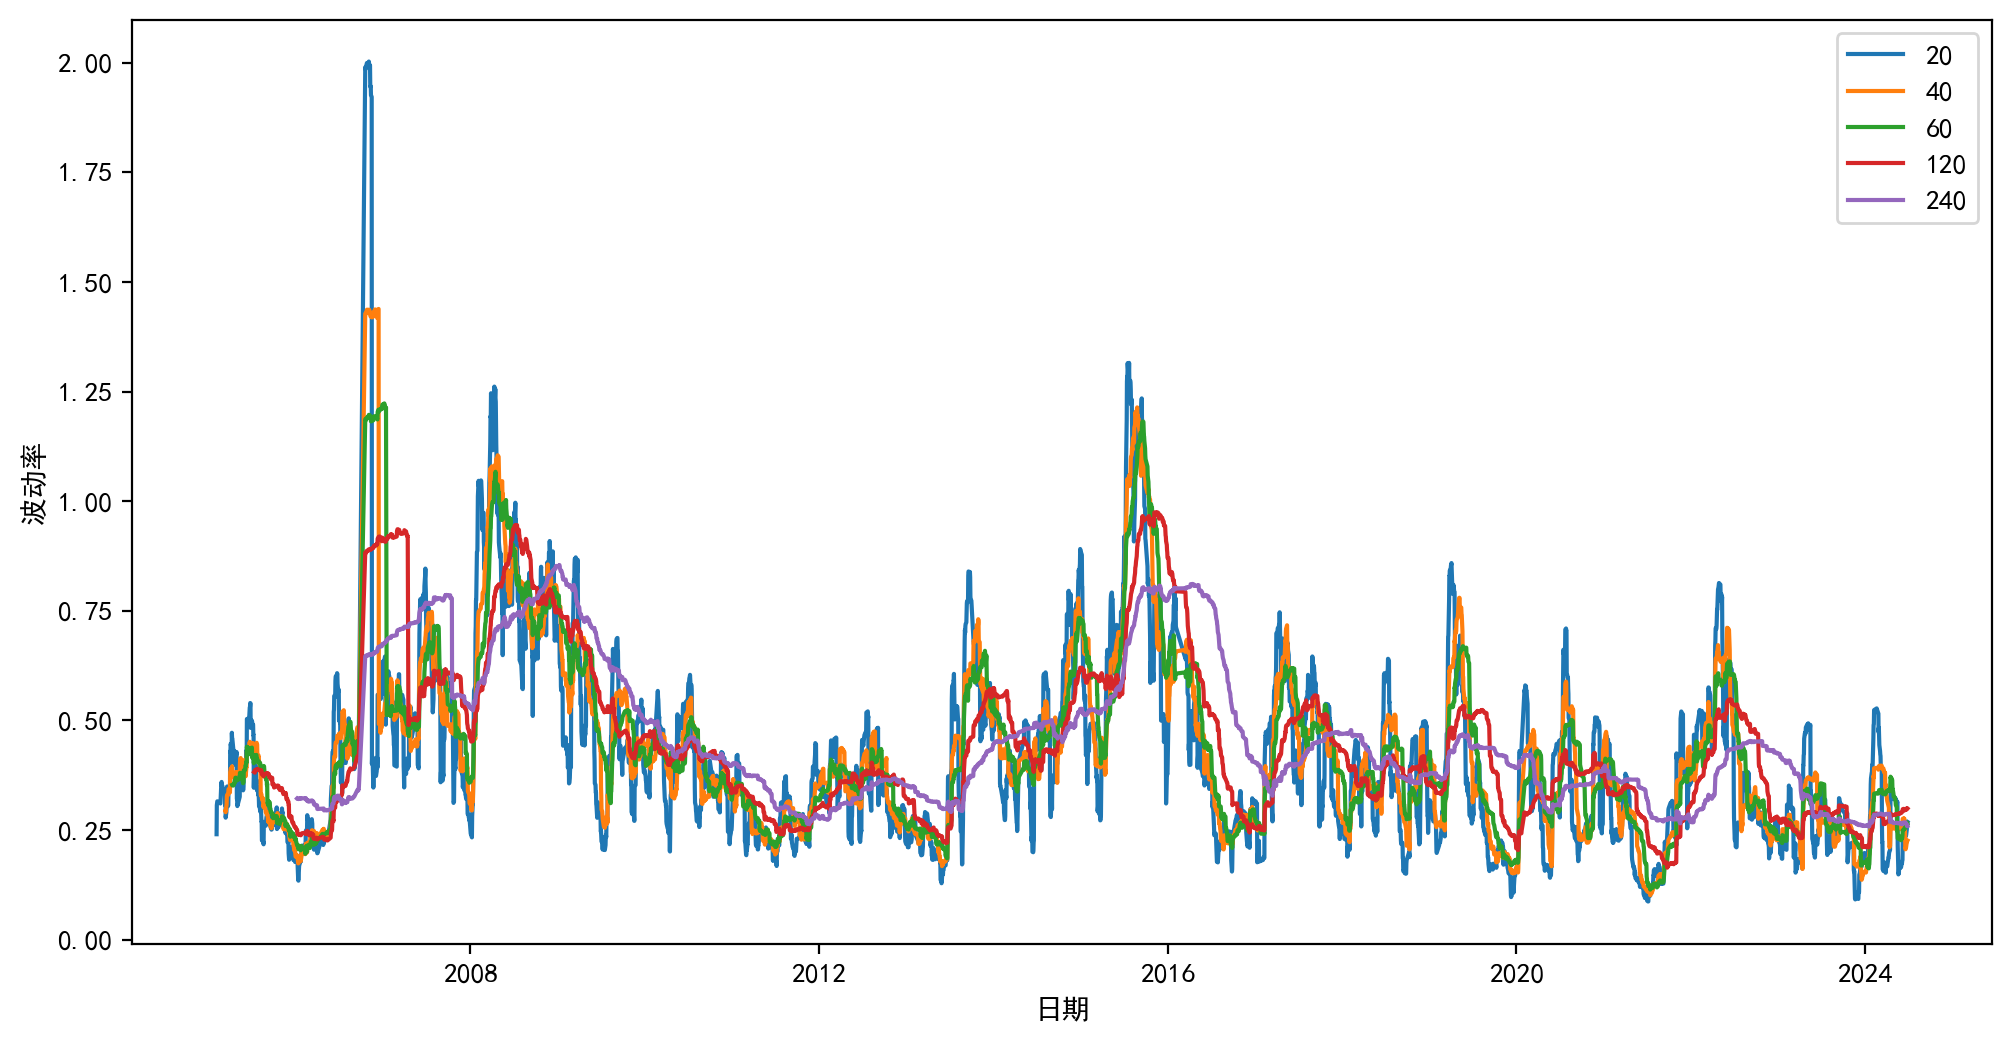

In [37]:
vol_dfs = []
for i in [20, 40, 60, 120, 240]:
    vol_dfs.append(
        price_df.loc[dt.datetime(2005, 1, 1) : dt.datetime.now()]
        .pct_change(fill_method=None)
        .rolling(i)
        .std()
        .dropna()
        * np.sqrt(252)
    )
vol_dfs = pd.concat(vol_dfs, axis=1)
vol_dfs.columns = [20, 40, 60, 120, 240]
plt.figure(figsize=(12, 6))
sns.lineplot(data=vol_dfs, dashes=False)
plt.ylabel("波动率")

Text(0, 0.5, '波动率')

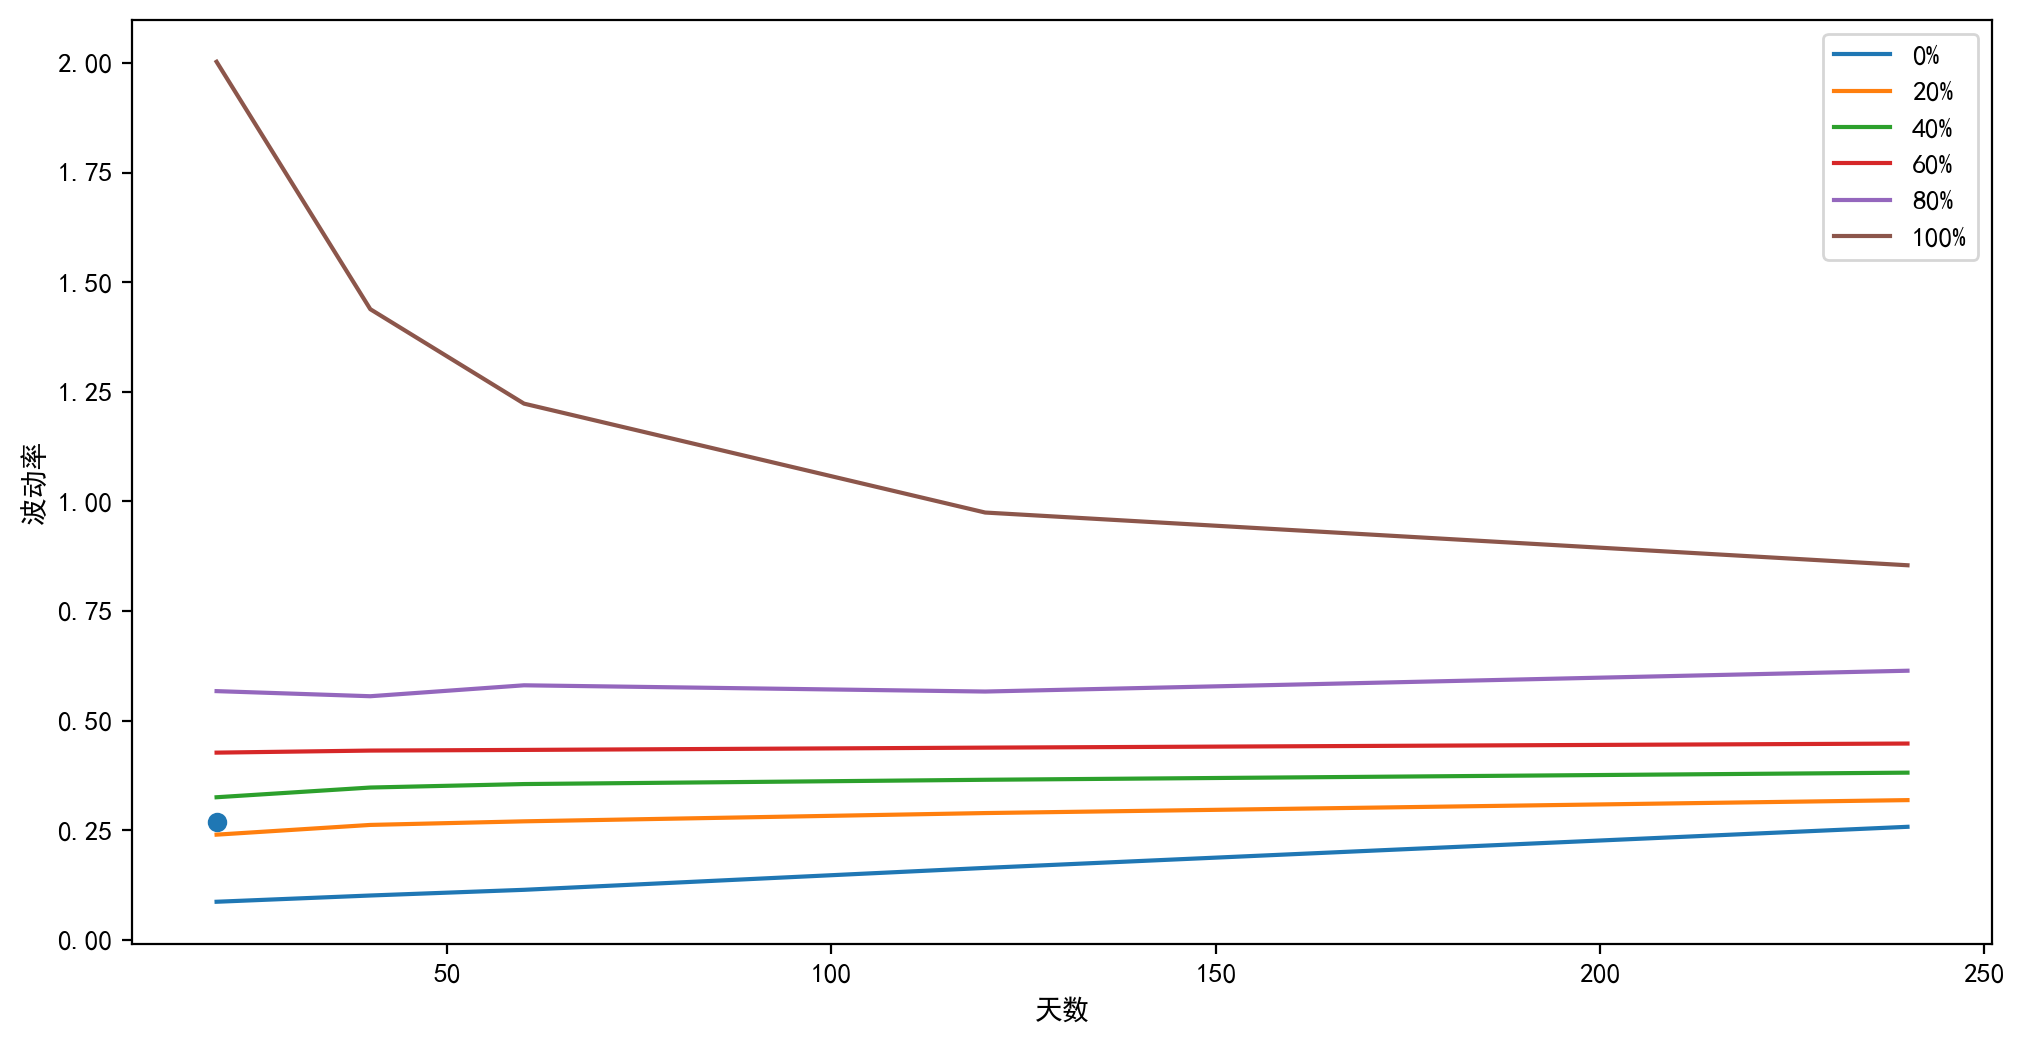

In [38]:
# 计算每个滑动窗口的波动率的历史分位数（最大、80%、60%、40%、20%、最小）
quantiles = [0, 0.2, 0.4, 0.6, 0.8, 1]
vol_quantiles = vol_dfs.quantile(quantiles)
vol_quantiles = vol_quantiles.T
vol_quantiles.columns = [f"{int(i*100)}%" for i in quantiles]
plt.figure(figsize=(12, 6))
sns.lineplot(data=vol_quantiles, dashes=False)
plt.scatter(x=20, y=vol_dfs.iloc[-1, 0])
plt.xlabel("天数")
plt.ylabel("波动率")

参数设定

In [39]:
vol = 0.25
s0 = price_df.loc[dt.datetime(2024, 1, 1) :].iloc[0]
ki = s0 * 0.8
ko = s0 * 1.1

calendar = price_df.index
calendar = calendar.append(
    pd.date_range(calendar[-1], calendar[-1] + rd.relativedelta(years=5), freq="B")
)

start_date = dt.datetime(2024, 1, 1)
end_date = dt.datetime(2026, 1, 1)
bt_start_date = dt.datetime(2024, 1, 1)
bt_end_date = dt.datetime.now()
buy_fee = 0.0005
sell_fee = 0.0015
cash = 1e6

敲入敲出-票息矩阵

  0%|          | 0/21 [00:00<?, ?it/s]

<Axes: >

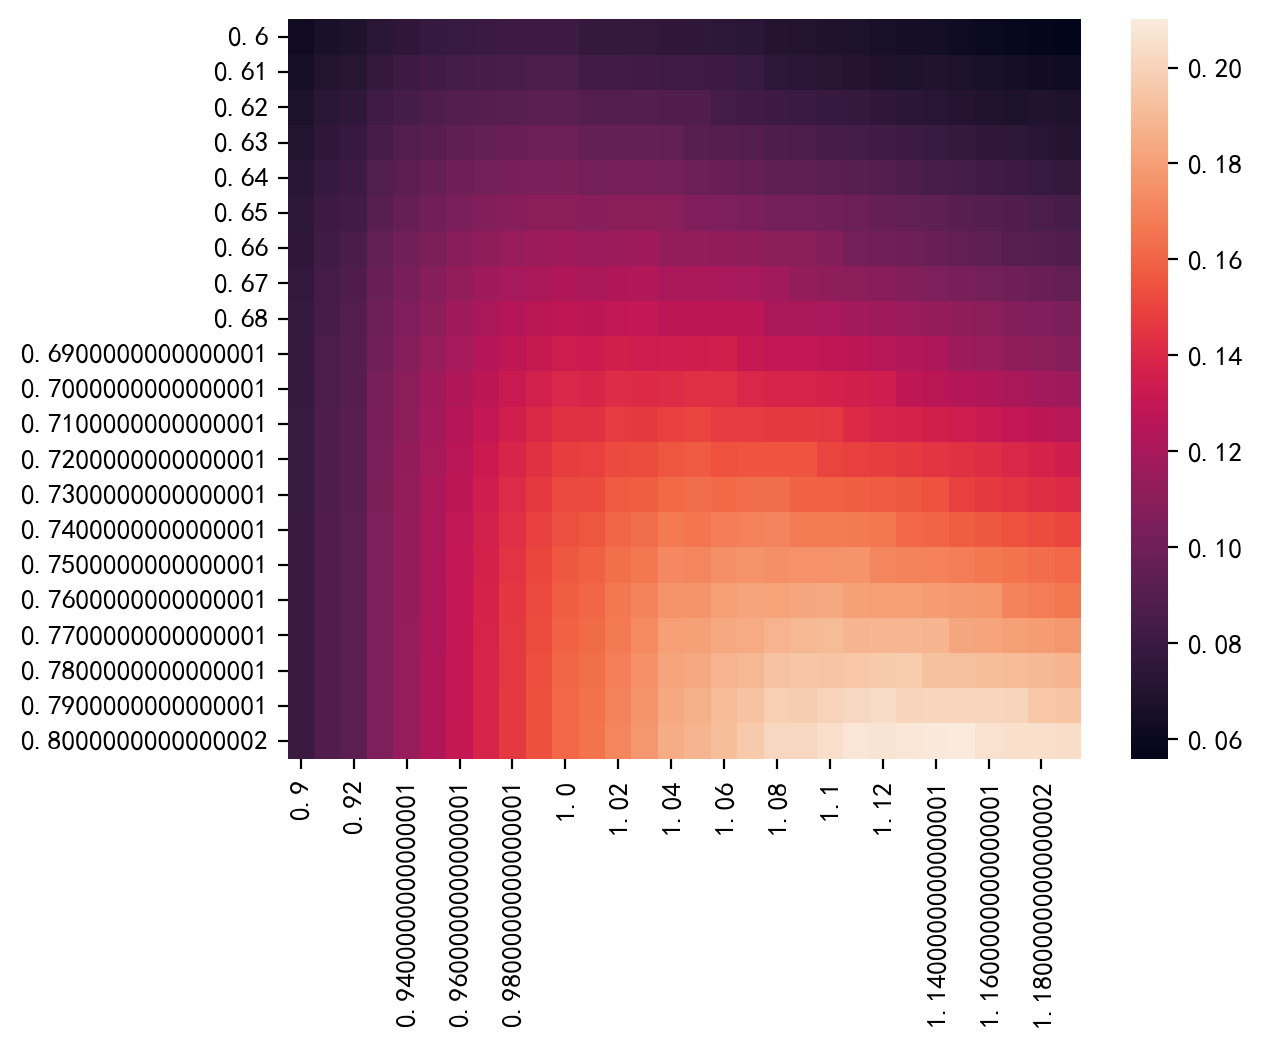

In [82]:
in_range = np.arange(0.60, 0.80, 0.01)
out_range = np.arange(0.90, 1.20, 0.01)


def get_coupon(i, j):
    ki = s0 * i
    ko = s0 * j
    # 暂时停止logging
    logging.disable(logging.INFO)

    def coupon2price(c):
        return (
            SnowballPDE(
                r=0.015,
                q=0.00,
                vol=vol,
                s0=s0,
                s=s0,
                start_date=start_date,
                end_date=end_date,
                calendar=calendar,
                lock_term=3,
                coupon_out=c,
                coupon_div=c,
                barrier_out=ko,
                barrier_in=ki,
                s_steps=800,
                grid_type="uniform",
            ).price()
            * 1e5
        )

    return bq(coupon2price, 0.0, 0.4)


results = Parallel(n_jobs=4)(
    delayed(get_coupon)(i, j) for i in tqdm(in_range) for j in out_range
)
coupon_mat = pd.DataFrame(
    np.reshape(results, [len(in_range), len(out_range)]),
    index=in_range,
    columns=out_range,
)
sns.heatmap(coupon_mat.astype(float))

雪球合约模拟

In [72]:
pde = SnowballPDE(
    r=0.015,
    q=0.00,
    vol=vol,
    s0=s0,
    s=s0,
    start_date=start_date,
    end_date=end_date,
    calendar=calendar,
    lock_term=3,
    coupon_out=0.15,
    coupon_div=0.15,
    barrier_out=ko,
    barrier_in=ki,
    s_steps=1600,
    grid_type="uniform",
)
pde.pv_and_greeks()

INFO:root:price执行完成，耗时1.1574194431304932秒


{'pv': -0.17058328341847454,
 'delta': 0.4753557197581896,
 'gamma': -0.3687051593957926}

In [62]:
mc = SnowballMC(
    r=0.015,
    q=0.00,
    vol=vol,
    s0=s0,
    s=s0,
    start_date=start_date,
    end_date=end_date,
    calendar=calendar,
    lock_term=3,
    coupon_out=0.15,
    coupon_div=0.15,
    barrier_out=ko,
    barrier_in=ki,
    n_paths=100000,
    seed=3407,
)
mc.pv_and_greeks()

INFO:root:price执行完成，耗时3.4405360221862793秒


{'pv': -0.18645190084566257,
 'delta': 0.4723007451278792,
 'gamma': 0.06535162754575449}

净值化雪球回测

In [20]:
# 初始化期权类
option = SnowballPDE(
    r=0.015,
    q=0.00,
    vol=vol,
    s0=s0,
    s=s0,
    start_date=start_date,
    end_date=end_date,
    calendar=calendar,
    lock_term=3,
    coupon_out=0.15,
    coupon_div=0.15,
    barrier_out=ko,
    barrier_in=ki,
    s_steps=2000,
)
pv = option.price()
logging.info(f"{stock}的期权价格为{pv}")
# 根据delta对冲获取仓位
bt_prices = price_df.loc[bt_start_date:bt_end_date]
daily_delta = []
for i in range(len(bt_prices)):
    daily_delta.append(option.delta(bt_prices.iloc[i], i))
# 根据delta推算仓位市值
delta_cash = pd.Series(
    cash * np.clip(np.array(daily_delta), 0, np.inf), index=bt_prices.index
)
# 计算delta_cash对应的仓位
amount = delta_cash / bt_prices
# 计算每日需要调整的仓位
amount_daily = amount.diff(1)
amount_daily.iloc[0] = amount.iloc[0]
# 计算每日交易现金流
trade = round(amount_daily) * bt_prices
# 计算交易费用
fee_ratio = np.where(trade >= 0, buy_fee, sell_fee)

# 考虑到单纯依据delta计算仓位可能会穿仓，每日重新计算仓位
cash_left = np.empty(len(bt_prices))
# 初始化第1个交易日的数据
amount_daily.iloc[0] = round(
    min(
        cash / (bt_prices.iloc[0] * (1 + fee_ratio[0])),
        delta_cash.iloc[0] / bt_prices.iloc[0],
    )
)
trade.iloc[0] = amount_daily.iloc[0] * bt_prices.iloc[0]
cash_left[0] = cash - trade.iloc[0] * (1 + fee_ratio[0])
amount.iloc[0] = amount_daily.iloc[0]

for i in range(1, len(bt_prices)):
    # 限制每日仓位调整幅度
    amount_daily.iloc[i] = round(
        min(
            cash_left[i - 1] / (bt_prices.iloc[i] * (1 + fee_ratio[i])),
            delta_cash.iloc[i] / bt_prices.iloc[i] - amount.iloc[i - 1],
        )
    )
    trade.iloc[i] = amount_daily.iloc[i] * bt_prices.iloc[i]
    cash_left[i] = cash_left[i - 1] - trade.iloc[i] * (1 + fee_ratio[i])
    # 更新当日delta_cash仓位
    amount.iloc[i] = amount.iloc[i - 1] + amount_daily.iloc[i]

# 计算持仓市值
snowball_positions = amount_daily.cumsum() * bt_prices
snowball_positions.rename(stock, inplace=True)
# 计算净值变化
snowball_returns = cash_left + snowball_positions - trade * fee_ratio
snowball_returns.rename(stock, inplace=True)

# 计算股票基准收益
stock_returns = round(cash / bt_prices.iloc[0]) * bt_prices

# 计算Gamma Scalping的基准收益
gs_bench_returns = cash_left[0] + amount.iloc[0] * bt_prices

# 回收内存
del (
    s0,
    vol,
    ki,
    ko,
    # price_df,
    calendar,
    cash,
    # option,
    pv,
    bt_prices,
    # daily_delta,
    delta_cash,
    cash_left,
    amount,
    amount_daily,
    trade,
    fee_ratio,
)
gc.collect()

snowball_returns.sort_index(inplace=True)
snowball_returns.ffill(inplace=True)
snowball_positions.sort_index(inplace=True)
snowball_positions.ffill(inplace=True)
stock_returns.sort_index(inplace=True)
stock_returns.ffill(inplace=True)
gs_bench_returns.sort_index(inplace=True)
gs_bench_returns.ffill(inplace=True)

PDE求解中:   0%|          | 0/511 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时13.662168025970459秒
INFO:root:000905的期权价格为-0.17314459230801338


回测结果整理

In [21]:
snowball_values = snowball_returns
snowball_returns = snowball_returns / 1e6 - 1
bench_return = stock_returns / 1e6 - 1
gs_bench_return = gs_bench_returns / 1e6 - 1
exceed_return = snowball_returns - bench_return
gs_exceed_return = snowball_returns - gs_bench_return
portfolio_position = snowball_positions / 1e6

result = pd.concat(
    [
        round(snowball_values, 0),
        snowball_returns.apply(lambda x: format(x, ".2%")),
        bench_return.apply(lambda x: format(x, ".2%")),
        exceed_return.apply(lambda x: format(x, ".2%")),
        gs_bench_return.apply(lambda x: format(x, ".2%")),
        gs_exceed_return.apply(lambda x: format(x, ".2%")),
        portfolio_position.apply(lambda x: format(x, ".2%")),
    ],
    axis=1,
)
result.columns = [
    "净值化雪球市值",
    "净值化雪球收益率",
    "股票基准收益率",
    "组合超额收益率",
    "Gamma Scalping基准收益率",
    "Gamma Scalping超额收益率",
    "仓位",
]
result.index = pd.to_datetime(result.index)
result.index.name = "日期"
result

,净值化雪球市值,净值化雪球收益率,股票基准收益率,组合超额收益率,Gamma Scalping基准收益率,Gamma Scalping超额收益率,仓位
日期,,,,,,,
2024-01-02,999523.0,-0.05%,-0.00%,-0.05%,-0.02%,-0.02%,47.68%
2024-01-03,1001772.0,0.18%,0.41%,-0.24%,0.17%,0.00%,46.63%
2024-01-04,1003059.0,0.31%,0.69%,-0.38%,0.31%,0.00%,45.93%
2024-01-05,1001146.0,0.11%,0.28%,-0.16%,0.11%,0.01%,47.09%
2024-01-08,988760.0,-1.12%,-2.34%,1.22%,-1.14%,0.02%,54.32%
...,...,...,...,...,...,...,...
2024-06-20,851467.0,-14.85%,-21.24%,6.39%,-10.15%,-4.70%,85.15%
2024-06-21,854449.0,-14.56%,-20.97%,6.41%,-10.02%,-4.53%,85.44%
2024-06-24,827608.0,-17.24%,-23.45%,6.21%,-11.20%,-6.03%,82.76%


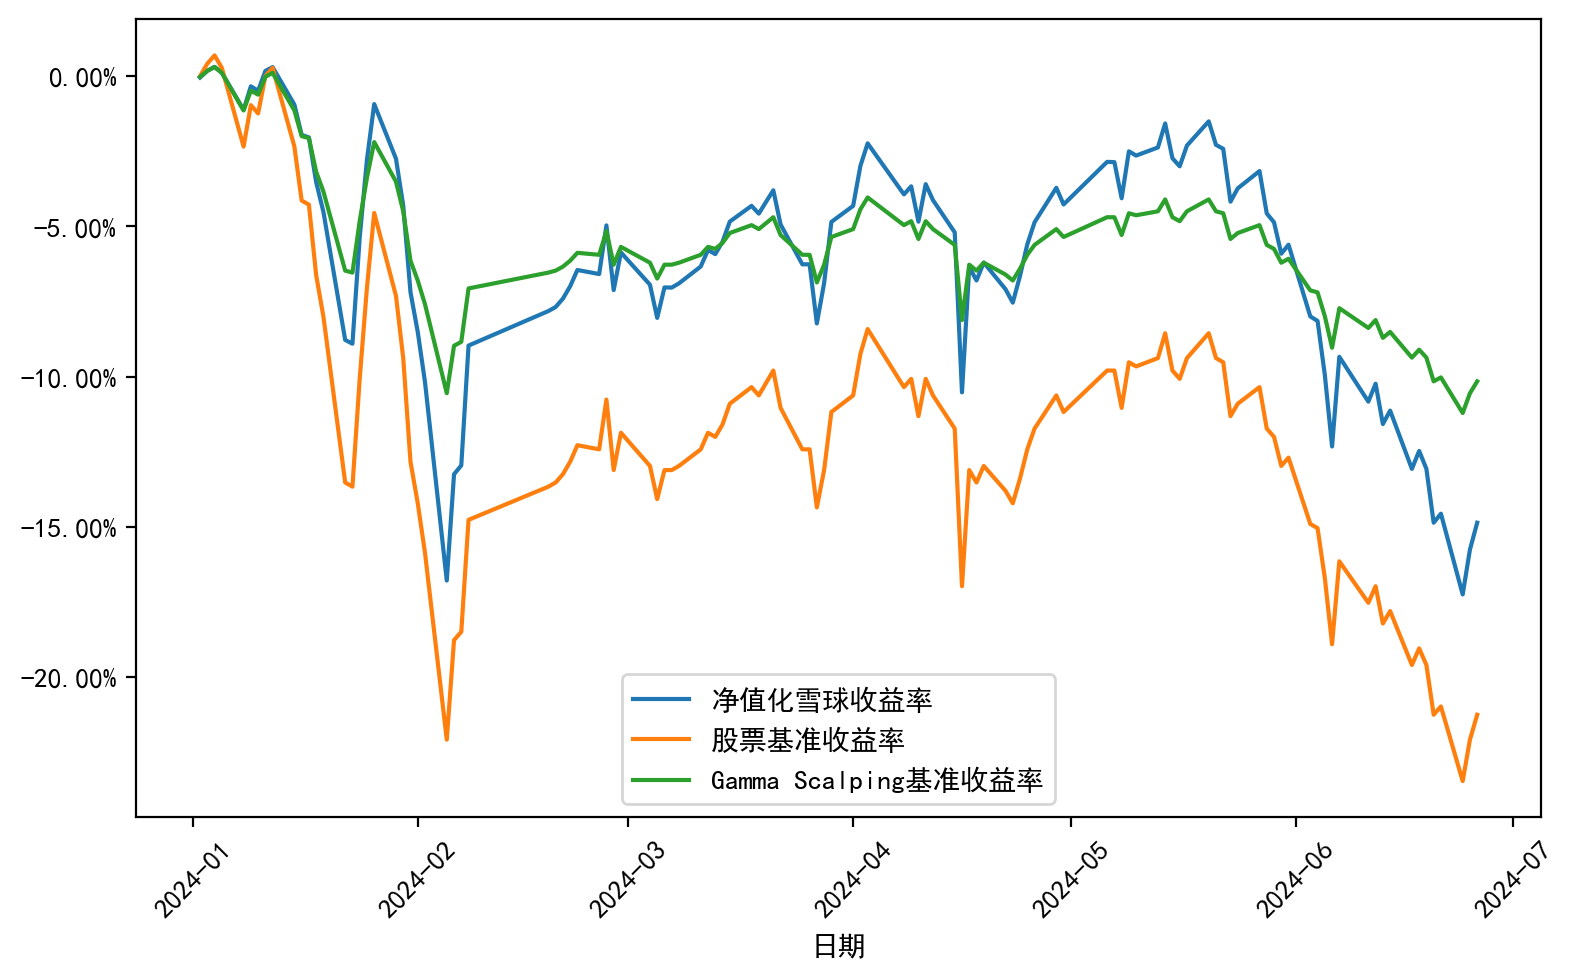

In [22]:
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()
returns = pd.concat([snowball_returns, bench_return, gs_bench_return], axis=1)
returns.columns = ["净值化雪球收益率", "股票基准收益率", "Gamma Scalping基准收益率"]
sns.lineplot(
    returns,
    dashes=False,
)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=2))
plt.xticks(rotation=45)
plt.tight_layout()

买卖点可视化

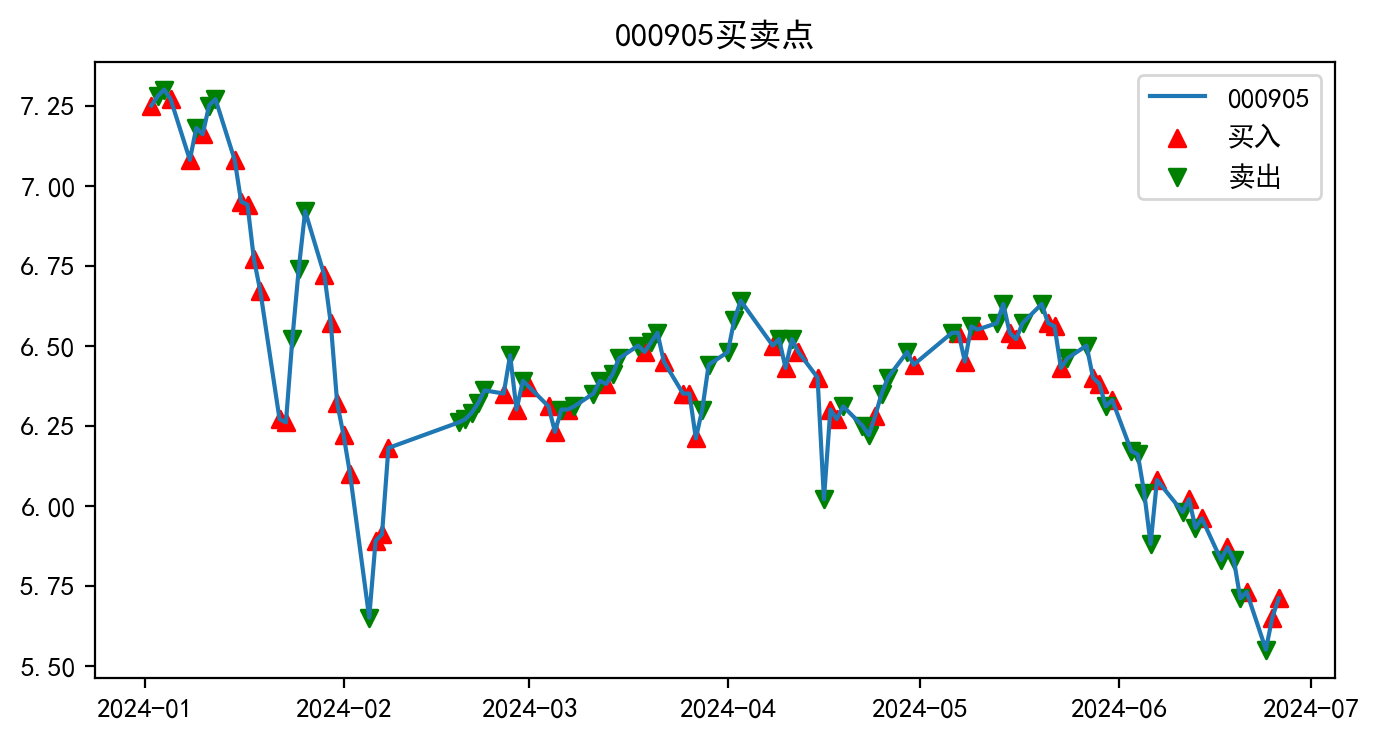

In [23]:
position_chg = snowball_positions.diff(1)
position_chg.iloc[0] = snowball_positions.iloc[0]
# 红色为买入，绿色为卖出
data = pd.concat([price_df.loc[bt_start_date:bt_end_date], position_chg], axis=1)
data.columns = ["价格", "仓位变化"]
plt.figure(figsize=(8, 4))
plt.plot(data["价格"], label=stock)
plt.scatter(
    data.loc[data["仓位变化"] > 0, "仓位变化"].index,
    data.loc[data["仓位变化"] > 0, "价格"],
    color="red",
    marker="^",
    label="买入",
)
plt.scatter(
    data.loc[data["仓位变化"] < 0, "仓位变化"].index,
    data.loc[data["仓位变化"] < 0, "价格"],
    color="green",
    marker="v",
    label="卖出",
)
plt.title(f"{stock}买卖点")
plt.legend()